In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import pickle
%matplotlib inline
import os

In [ ]:
## Example ##


image Shape (720, 1280, 3)


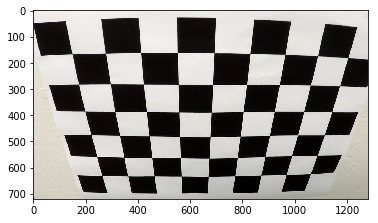

In [2]:
img = mpimg.imread('camera_cal/calibration2.jpg')
image_shape = img.shape
print("image Shape",image_shape)
plt.imshow(img)

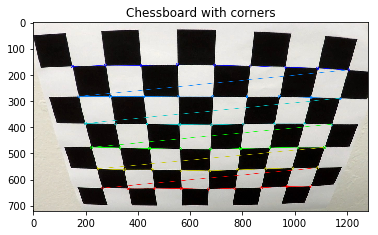

In [3]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard with corners")
    plt.show()

In [4]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)

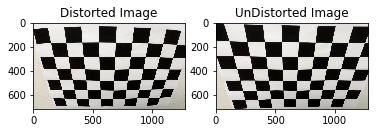

In [5]:
img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Distorted Image")
plt.subplot(1,2,2)
plt.imshow(undistorted)
plt.title("UnDistorted Image")

In [6]:
def undistortImage(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img
        
    
    

In [7]:
## HLS trasnformations:
def hls_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresh = (160, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return s_binary

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


In [9]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [11]:
def sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary):
    combined = np.zeros_like(dir_binary)
    combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    

In [12]:
def sobel_schannel_combined(sobelCombined,s_binary):
    combined_binary = np.zeros_like(sobelCombined)
    combined_binary[(s_binary == 1) | (sobelCombined == 1)] = 1
    
    return combined_binary



In [29]:
def perspectiveTransform(img,gaussian_combined_binary):
    bottom_left = [283,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    src = np.float32([bottom_left,bottom_right,top_right,top_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    image_shape=img.shape
    img_size = (image_shape[1], image_shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(gaussian_combined_binary, M, img_size)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(copy)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped

In [14]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

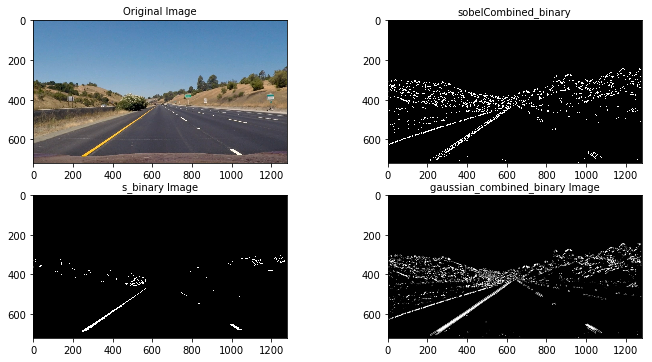

--------------------------------


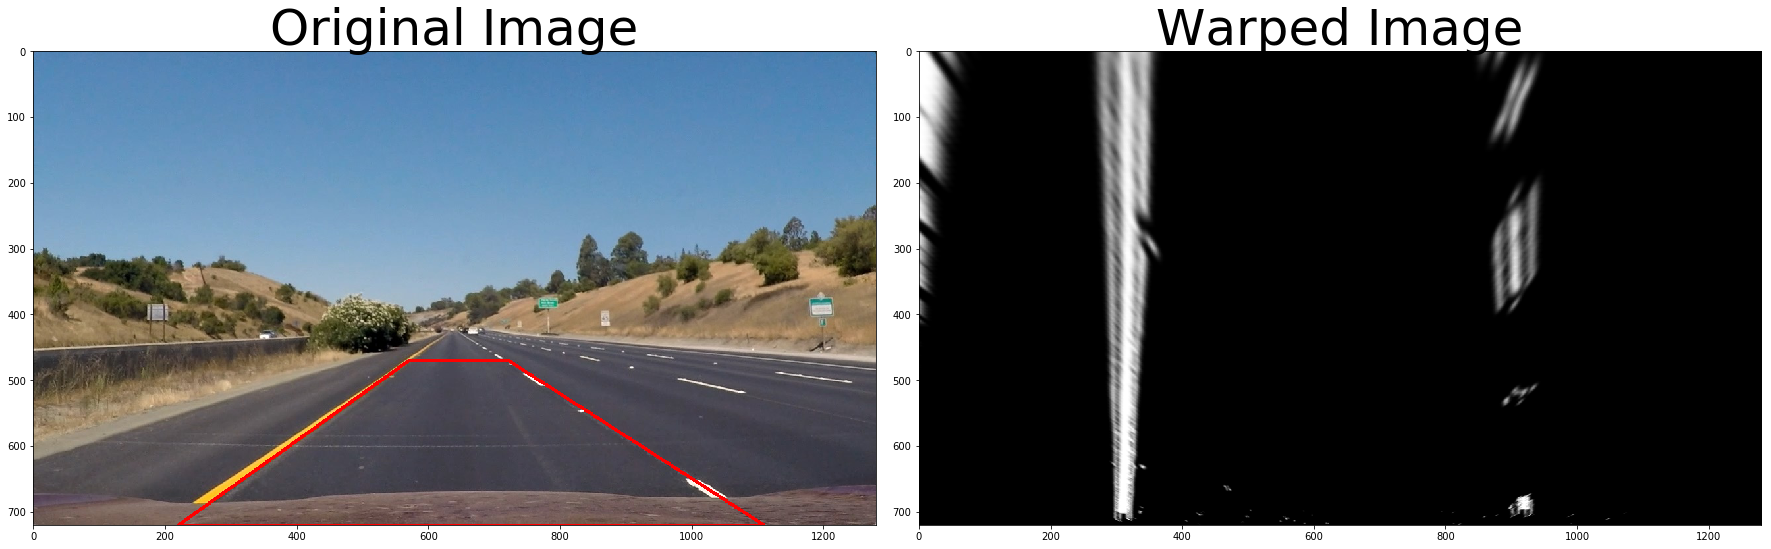

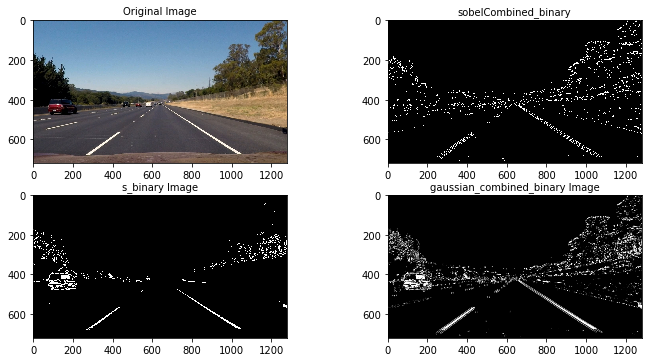

--------------------------------


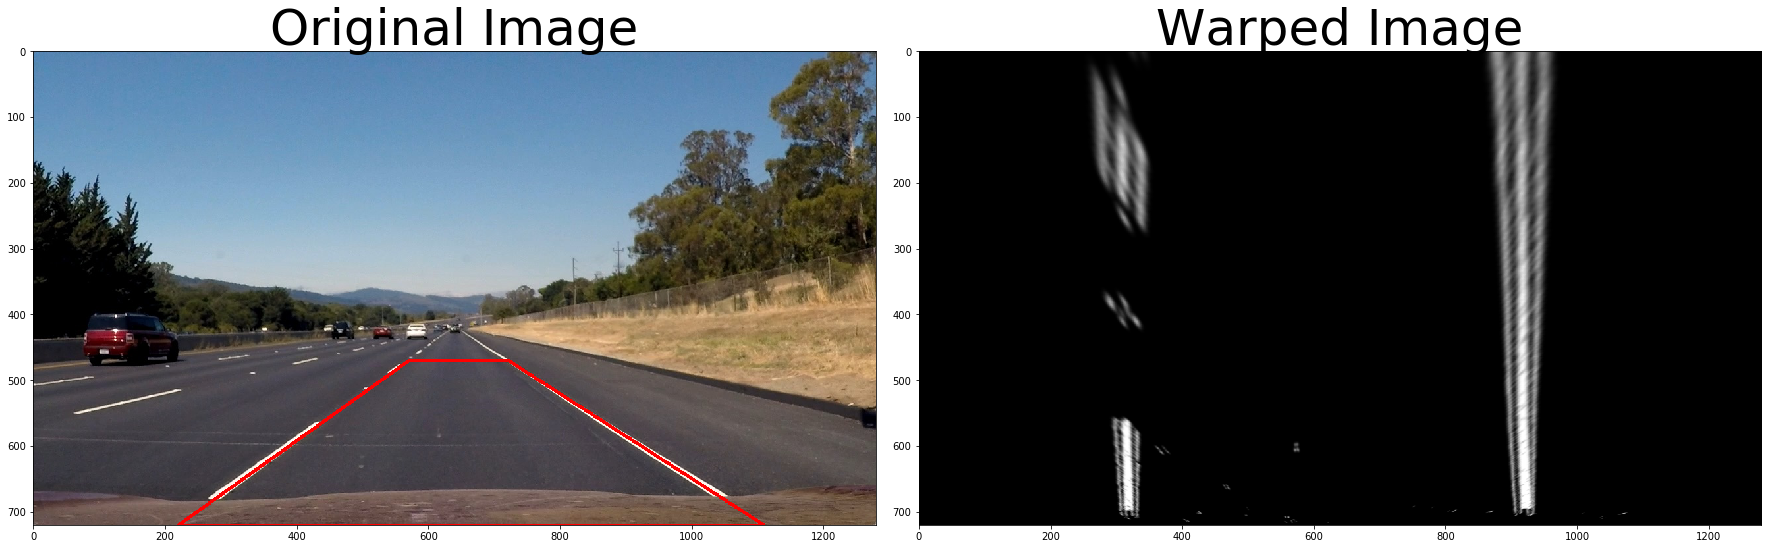

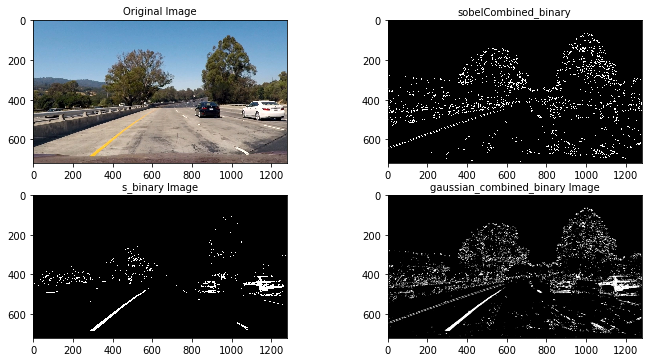

--------------------------------


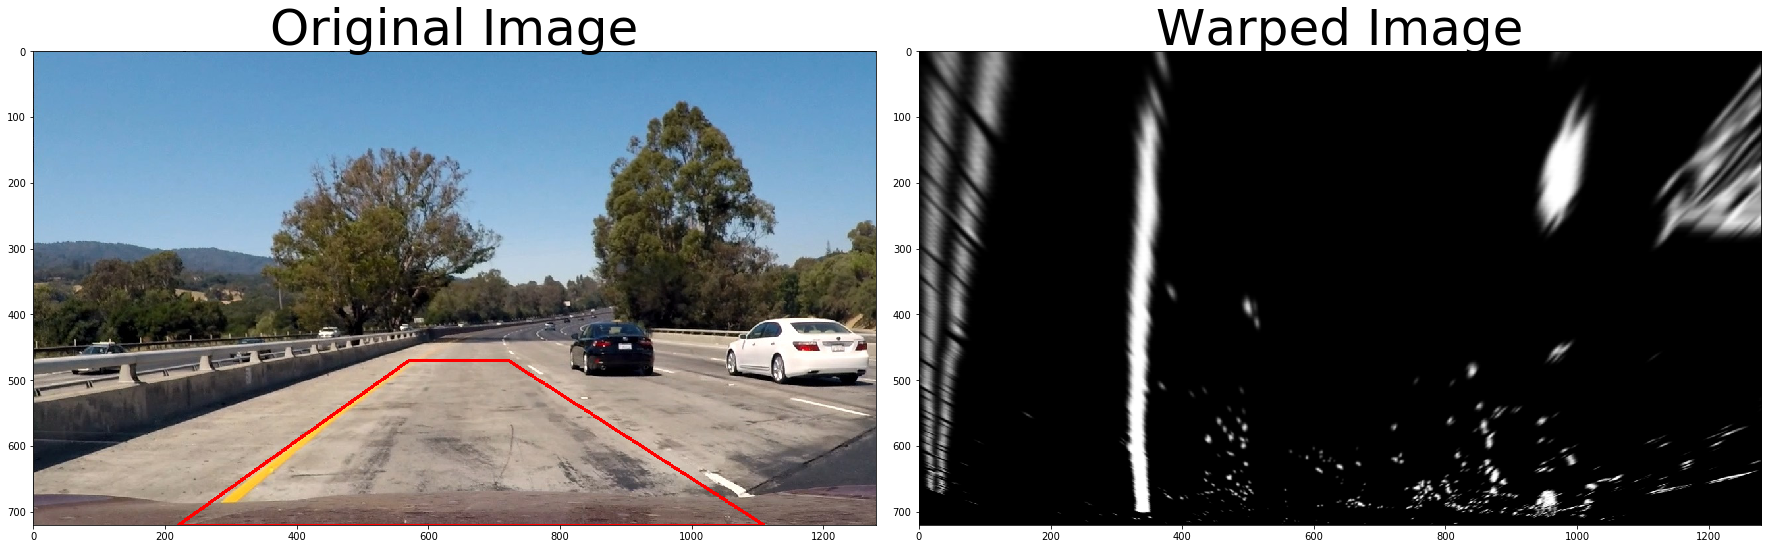

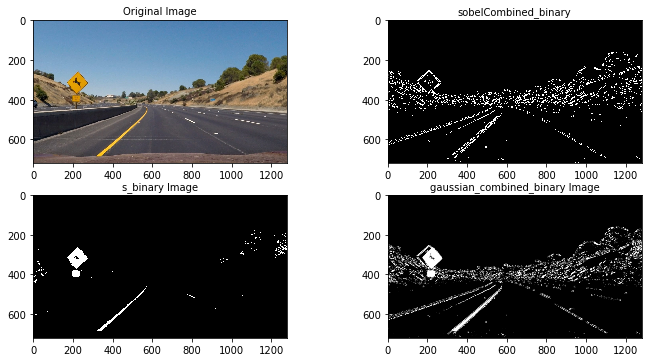

--------------------------------


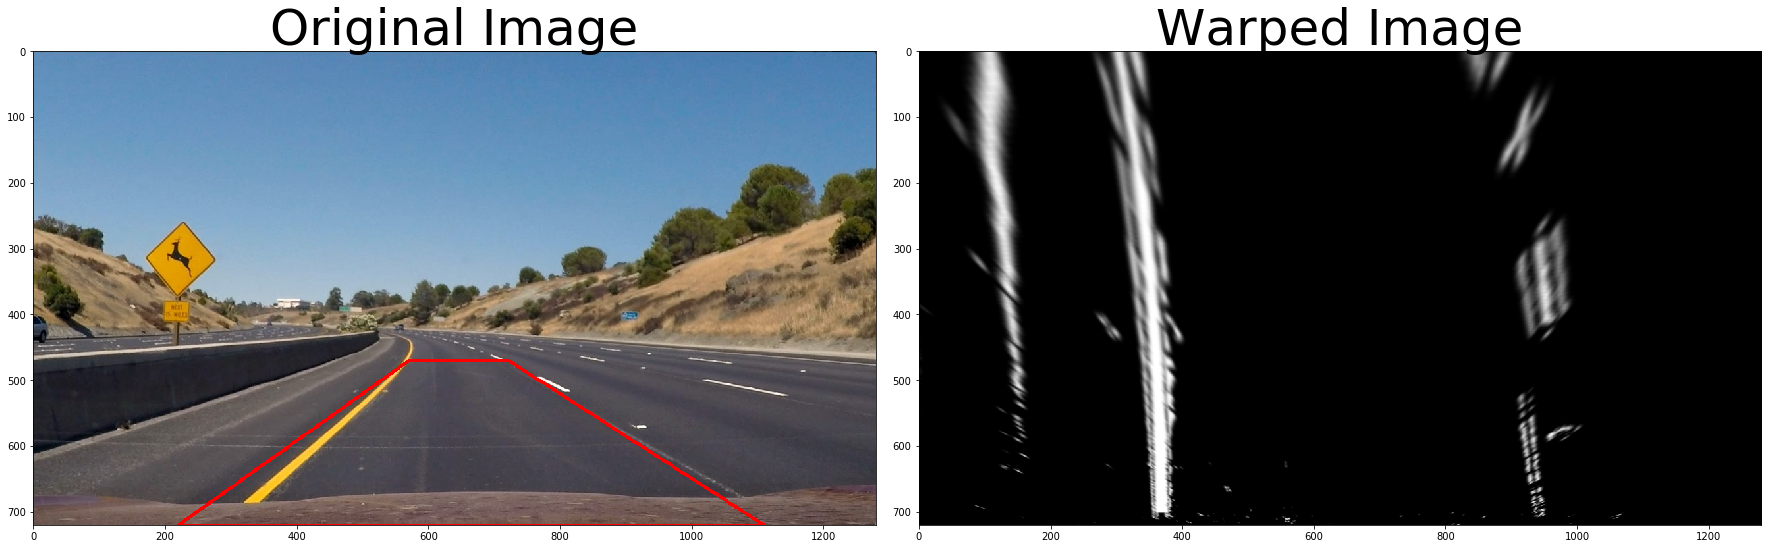

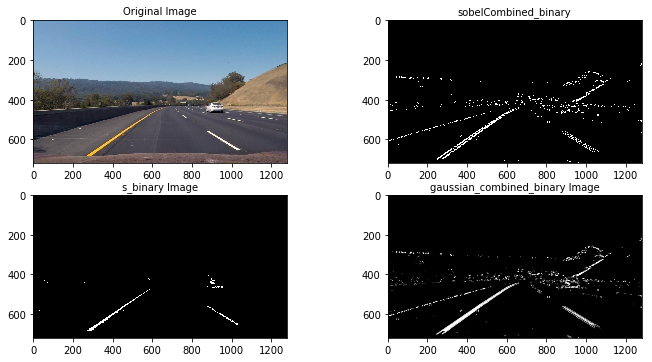

--------------------------------


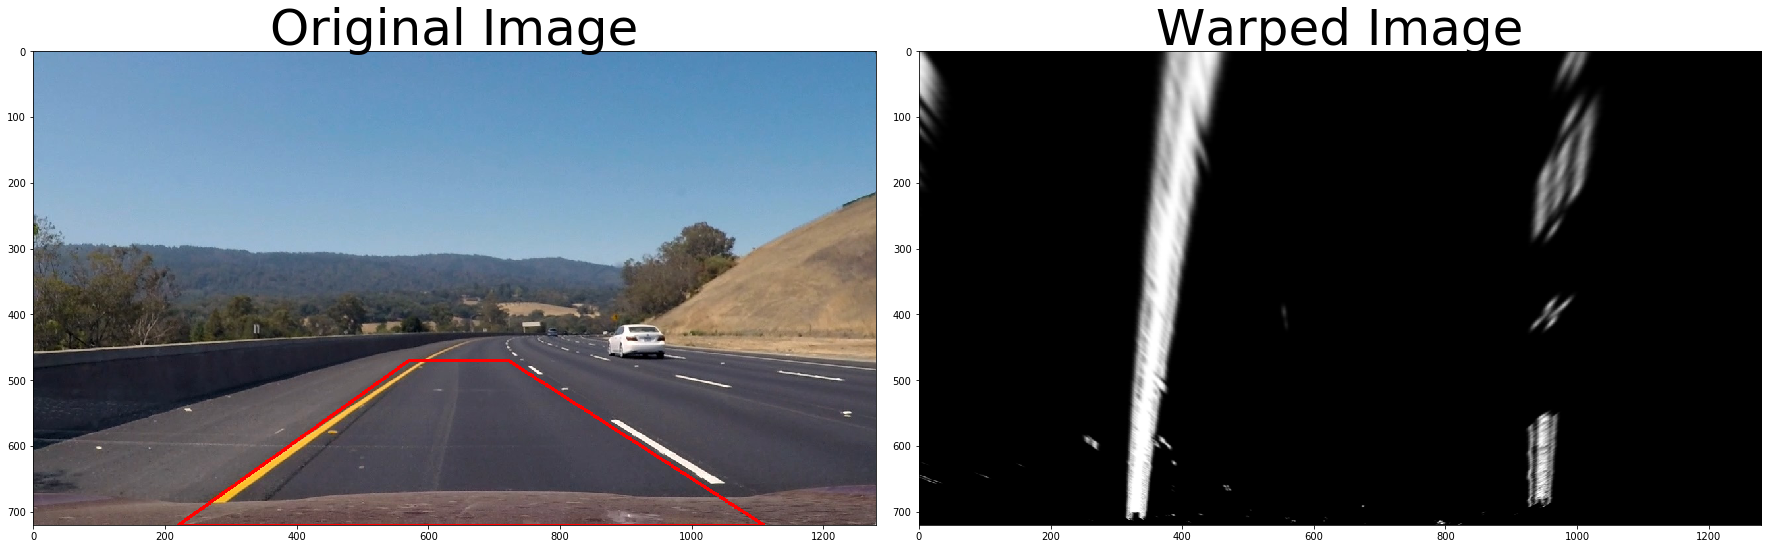

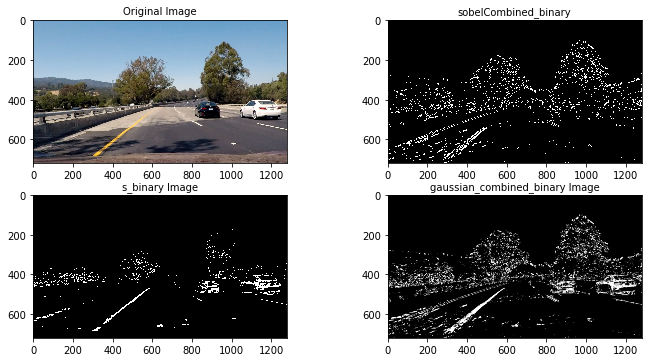

--------------------------------


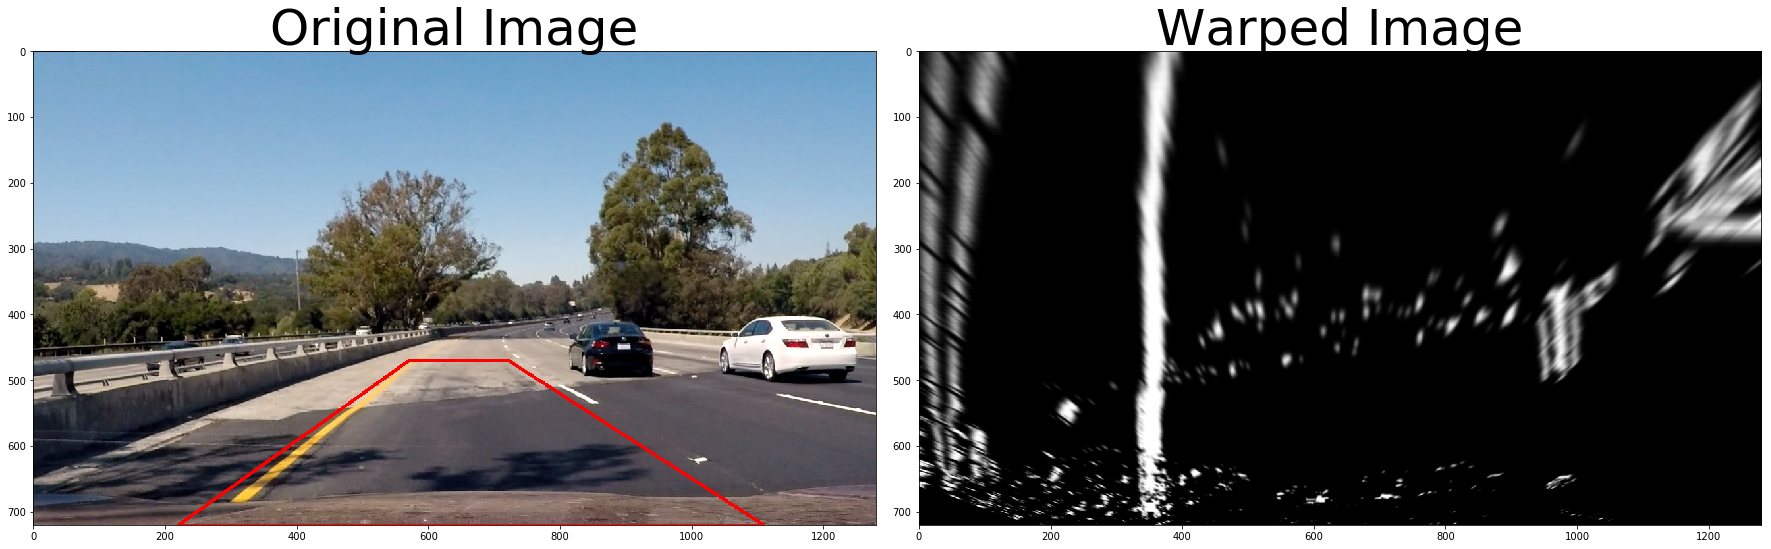

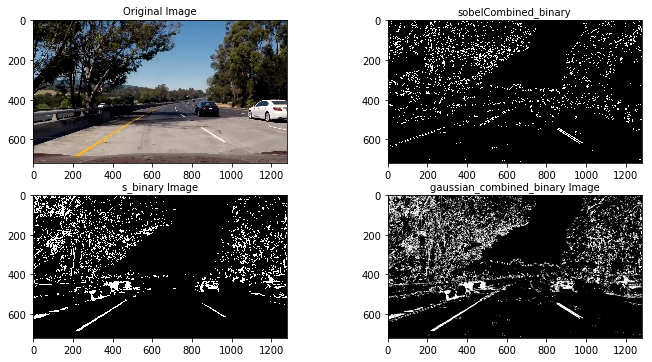

--------------------------------


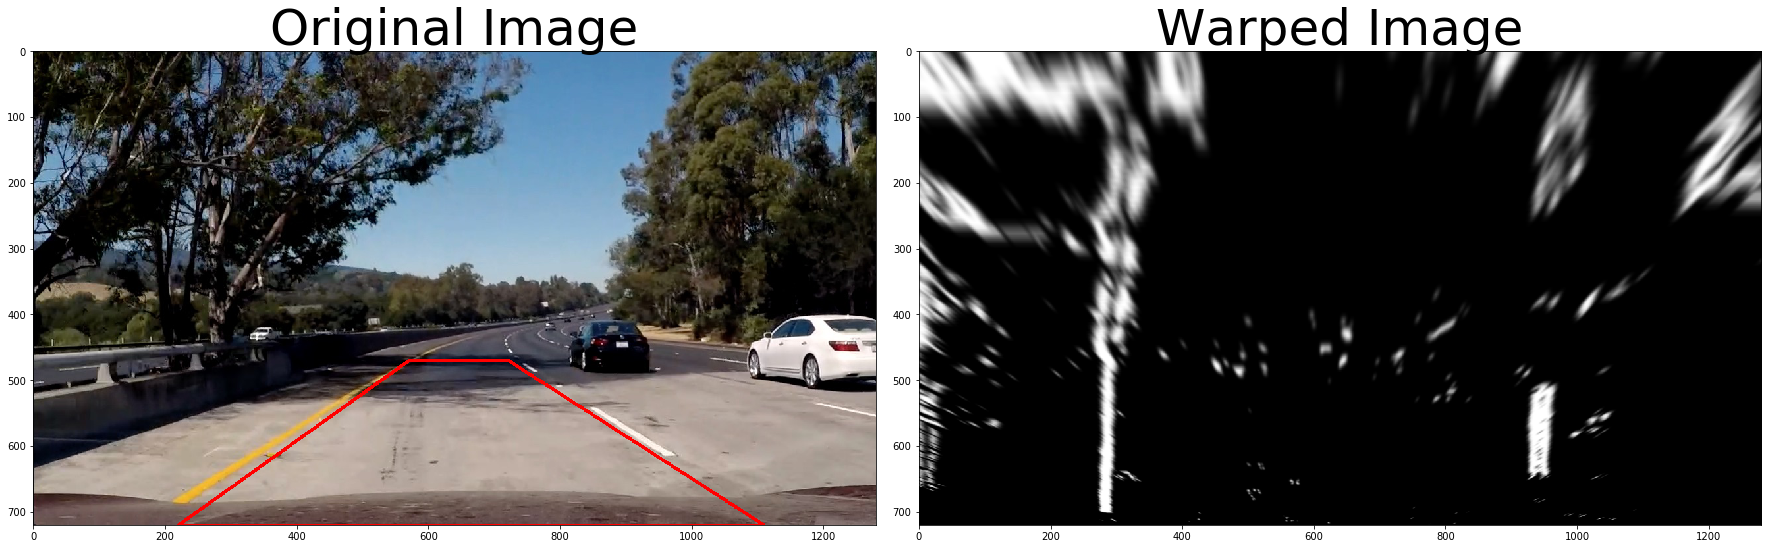

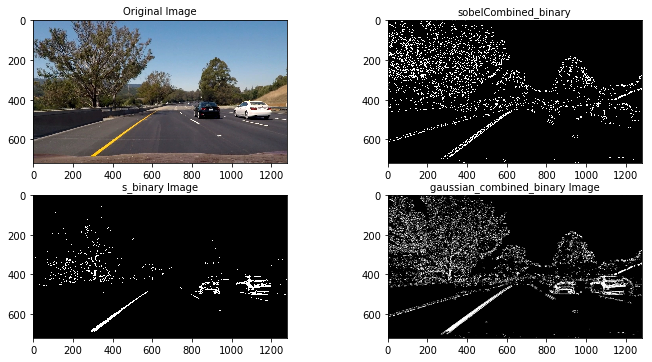

--------------------------------


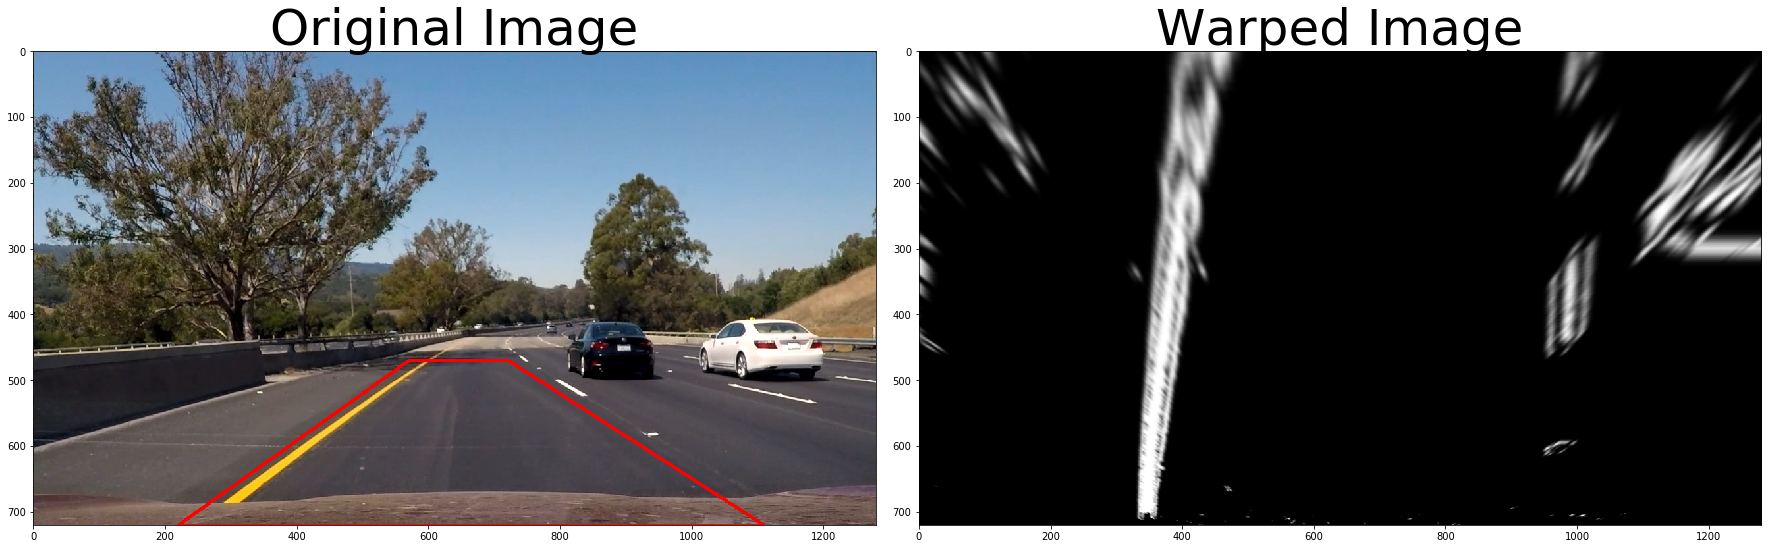

In [28]:
images = os.listdir('./test_images')  
for image in images:
    image = os.path.join('test_images',image)
    #print(image)
    img = mpimg.imread(image)
    #img = cv2.resize(img, (720, 405))
    
    s_binary=hls_binary(img)
    undistImg=undistortImage(img)
    gray = cv2.cvtColor(undistImg, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    sx_binary=abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=100)
    sy_binary=abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=100)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray,sobel_kernel=15,thresh=(0.7, 1.3))
    mag_binary=mag_thresh(gray, sobel_kernel=15, mag_thresh=(30, 100))
    
    sobelCombined_binary=sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary)
    
    combined_binary=sobel_schannel_combined(sobelCombined_binary,s_binary)
    gaussian_combined_binary=gaussian_blur(combined_binary, 5)
    
    #f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
    #f, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5, figsize=(10, 5))
    #f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(10, 5))
    #f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(10, 5))
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img,cmap="gray")
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(sobelCombined_binary,cmap="gray")
    ax2.set_title('sobelCombined_binary', fontsize=10)
    ax3.imshow(s_binary,cmap="gray")
    ax3.set_title('s_binary Image', fontsize=10)
    ax4.imshow(gaussian_combined_binary,cmap="gray")
    ax4.set_title('gaussian_combined_binary Image', fontsize=10)
    #ax5.imshow(gaussian_combined_binary,cmap="gray")
    #ax5.set_title('gaussian_combined_binary Image', fontsize=10)
    #ax6.imshow(sy_binary,cmap="gray")
    #ax6.set_title('sy_binary Image', fontsize=10)
    #ax7.imshow(s_binary,cmap="gray")
    #ax7.set_title('s_binary Image', fontsize=10)
    #ax8.imshow(combined_binary,cmap="gray")
    #ax8.set_title('combined_binary Image', fontsize=10)
    #ax9.imshow(img,cmap="gray")
    #ax9.set_title('Original Image', fontsize=10)
    plt.show()
    print("--------------------------------")
    #ax2.set_title('Transformed', fontsize=20)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    warped_image=perspectiveTransform(img,gaussian_combined_binary)


image Shape (720, 1280, 3)


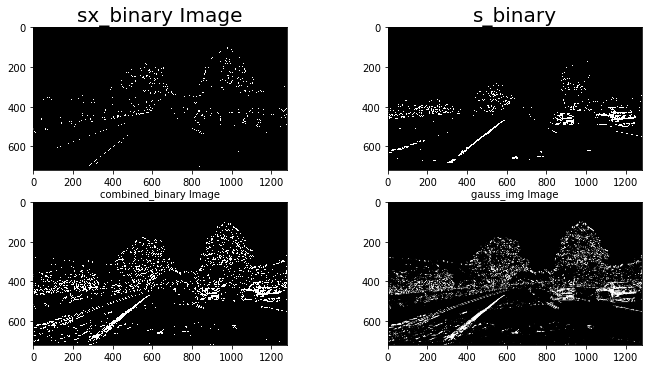

--------------------------------


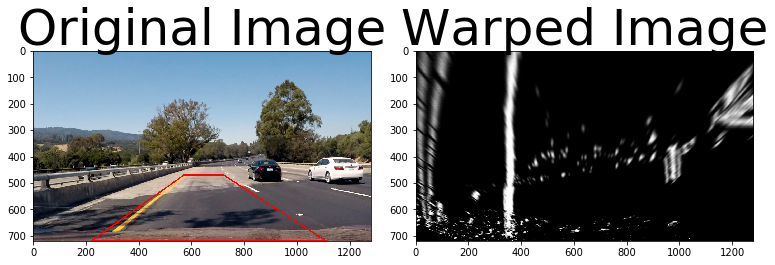

In [30]:
img = mpimg.imread('test_images/test4.jpg')
image_shape = img.shape
print("image Shape",image_shape)
 
s_binary=hls_binary(img)
undistImg=undistortImage(img)
gray = cv2.cvtColor(undistImg, cv2.COLOR_RGB2GRAY)
height, width = gray.shape
sx_binary=abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=100)
sy_binary=abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=100)
    
# apply gradient direction threshold so that only edges closer to vertical are detected.
dir_binary = dir_threshold(gray,sobel_kernel=15,thresh=(0.7, 1.3))
mag_binary=mag_thresh(gray, sobel_kernel=15, mag_thresh=(30, 100))
    
sobelCombined_binary=sobelCombined(sx_binary,sy_binary, dir_binary,mag_binary)
    
combined_binary=sobel_schannel_combined(sobelCombined_binary,s_binary)
gauss_img=gaussian_blur(combined_binary, 5) 


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(sx_binary,cmap="gray")
ax1.set_title('sx_binary Image', fontsize=20)
ax2.imshow(s_binary,cmap="gray")
ax2.set_title('s_binary', fontsize=20)
ax3.imshow(combined_binary,cmap="gray")
ax3.set_title('combined_binary Image', fontsize=10)
ax4.imshow(gauss_img,cmap="gray")
ax4.set_title('gauss_img Image', fontsize=10)
plt.show()
print("--------------------------------")
warped_image=perspectiveTransform(img,gauss_img)